In [1]:
# General imports

import matplotlib.pyplot as plt
import os
import random
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers

In [2]:
# prompt: download and extract images from url https://mmlab.ie.cuhk.edu.hk/archive/cufsf/files/original_sketch.zip

!wget https://mmlab.ie.cuhk.edu.hk/archive/cufsf/files/original_sketch.zip
!unzip original_sketch.zip


--2024-02-01 09:03:33--  https://mmlab.ie.cuhk.edu.hk/archive/cufsf/files/original_sketch.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.16
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85755238 (82M) [application/zip]
Saving to: ‘original_sketch.zip’

original_sketch.zip 100%[===================>]  81.78M  3.12MB/s    in 31s     

2024-02-01 09:04:04 (2.66 MB/s) - ‘original_sketch.zip’ saved [85755238/85755238]

Archive:  original_sketch.zip
   creating: original_sketch/
  inflating: original_sketch/00001.jpg  
  inflating: original_sketch/00002.jpg  
  inflating: original_sketch/00003.jpg  
  inflating: original_sketch/00004.jpg  
  inflating: original_sketch/00005.jpg  
  inflating: original_sketch/00006.jpg  
  inflating: original_sketch/00007.jpg  
  inflating: original_sketch/00008.jpg  
  inflating: original_sketch/00009.jpg  
  inflating: original_sketch/

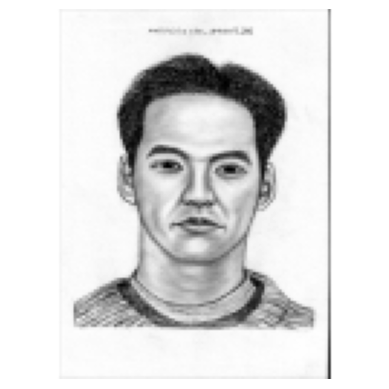

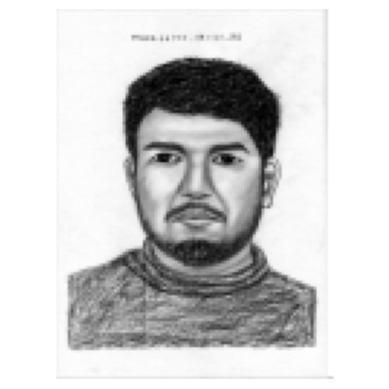

In [3]:
# prompt: display some of the previously downloaded images


# Get a list of all the files in the directory
files = os.listdir('original_sketch')

# Choose a random sample of 5 files
sample_files = random.sample(files, 2)

# Display each image
for file in sample_files:
  img = cv2.imread(os.path.join('original_sketch', file))
  im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  im_gray = cv2.resize(im_gray, (128,128), interpolation = cv2.INTER_AREA)
  plt.imshow(im_gray, cmap = 'gray')
  plt.axis("off")
  plt.show()



In [4]:
# prompt: convert images in original_sketch folder into a list of images split it between training and testing data


# im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)

# Get a list of all files in the directory
files = os.listdir('original_sketch')

# Load all images into a list
images = []
for file in files:
  img = cv2.imread(os.path.join('original_sketch', file))
  im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  im_gray = cv2.resize(im_gray, (128,128), interpolation = cv2.INTER_AREA)

  images.append(im_gray)

# images = np.array(images) # convert the list to a NumPy array

# Split the images into training and testing sets
x_train, x_test = train_test_split(images, test_size=0.2)

# images_array = np.array([np.asarray(image) for image in images])

# # Convert the training and testing sets to numpy arrays
# x_train = np.array(x_train)
# x_test = np.array(x_test)
# X_train = tf.stack(x_train, axis=0)
# X_test = tf.stack(x_test, axis=0)
X_train = np.stack(x_train, axis=0)
X_test = np.stack(x_test, axis=0)


X_train = X_train.astype('float32') / 127.5 - 1
X_test = X_test.astype('float32') / 127.5 - 1

X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)

In [5]:
x_train = X_train
x_test = X_test

# Define the encoder model
# Use convolutional layers with kernel size 3 and stride 2 as downsampling
# Double the number of channels before downsampling
# Use batch normalization after each convolutional layer
# Use regular ReLU activations
def encoder_model():
  inputs = keras.Input(shape=(128, 128, 1)) # input shape of CUFSF images
  x = layers.Conv2D(32, 3, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(64, 3, 2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(128, 3, 2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(256, 3, 2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(64)(x) # latent dimensionality of 64 channels
  return keras.Model(inputs, outputs, name='encoder')

# Define the decoder model
# Use transpose convolutional layers or resize the activation maps as upsampling
# Halve the number of channels after upsampling
# Use batch normalization after each convolutional layer
# Use regular ReLU activations except for the last layer with Tanh activations
def decoder_model():
  inputs = keras.Input(shape=(64,)) # latent dimensionality of 64 channels
  x = layers.Dense(16 * 16 * 256)(inputs)
  x = layers.Reshape((16, 16, 256))(x)
  x = layers.Conv2DTranspose(128, 3, 2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2DTranspose(64, 3, 2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2DTranspose(32, 3, 2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  outputs = layers.Conv2DTranspose(3, 3, activation='tanh', padding='same')(x) # output shape of CUFSF images
  return keras.Model(inputs, outputs, name='decoder')

# Build the autoencoder model
# Use the encoder and decoder models as sequential layers
encoder = encoder_model()
decoder = decoder_model()
autoencoder = keras.Sequential([encoder, decoder])

# Compile the autoencoder model
# Use Adam optimizer with beta_1 = 0.5
# Use L2 reconstruction loss
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=1e-4, beta_1=0.5), loss=losses.MeanSquaredError())

# Train the autoencoder model
# Use 5000 iterations and batch size of 64
# Shuffle the data and use validation data
autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_test, x_test))



Epoch 1/100
15/15 [==============================] - 12s 167ms/step - loss: 0.9837 - val_loss: 0.6860
Epoch 2/100
15/15 [==============================] - 0s 33ms/step - loss: 0.4893 - val_loss: 0.6680
Epoch 3/100
15/15 [==============================] - 1s 34ms/step - loss: 0.3100 - val_loss: 0.6453
Epoch 4/100
15/15 [==============================] - 1s 34ms/step - loss: 0.2334 - val_loss: 0.6206
Epoch 5/100
15/15 [==============================] - 1s 34ms/step - loss: 0.1838 - val_loss: 0.5931
Epoch 6/100
15/15 [==============================] - 1s 34ms/step - loss: 0.1579 - val_loss: 0.5626
Epoch 7/100
15/15 [==============================] - 1s 34ms/step - loss: 0.1360 - val_loss: 0.5301
Epoch 8/100
15/15 [==============================] - 0s 33ms/step - loss: 0.1192 - val_loss: 0.4967
Epoch 9/100
15/15 [==============================] - 0s 34ms/step - loss: 0.1109 - val_loss: 0.4626
Epoch 10/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0992 - val_loss: 0.42

1/1 [==============================] - 0s 20ms/step


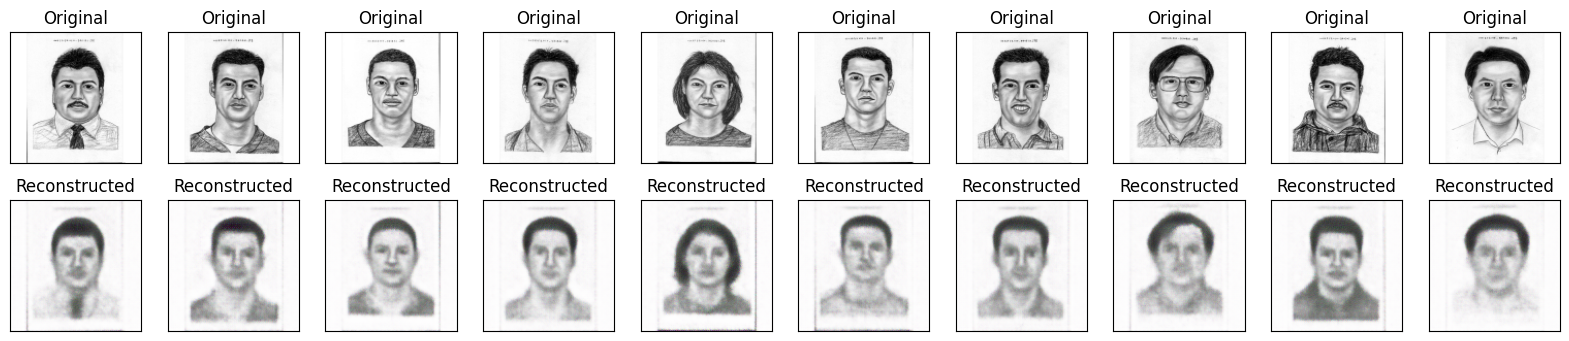

In [6]:

# Plot some original and reconstructed images
# Use matplotlib.pyplot to show the images
n = 10 # number of images to show
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow((x_test[i] + 1) / 2, cmap = 'gray') # rescale the images to [0, 1]
  plt.title("Original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstructed images
  ax = plt.subplot(2, n, i + 1 + n)
  reconstructed = autoencoder.predict(x_test[i:i+1]) # get the reconstructed image
  plt.imshow((reconstructed[0] + 1) / 2) # rescale the images to [0, 1]
  plt.title("Reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
# Train the autoencoder model
# Use 5000 iterations and batch size of 64
# Shuffle the data and use validation data
autoencoder.fit(x_train, x_train, epochs=2000, batch_size=64, shuffle=True, validation_data=(x_test, x_test))


Epoch 1/2000
15/15 [==============================] - 1s 41ms/step - loss: 0.0191 - val_loss: 0.0267
Epoch 2/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0179 - val_loss: 0.0278
Epoch 3/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0181 - val_loss: 0.0271
Epoch 4/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0175 - val_loss: 0.0277
Epoch 5/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0181 - val_loss: 0.0267
Epoch 6/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0176 - val_loss: 0.0270
Epoch 7/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0171 - val_loss: 0.0267
Epoch 8/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0187 - val_loss: 0.0491
Epoch 9/2000
15/15 [==============================] - 1s 34ms/step - loss: 0.0201 - val_loss: 0.0266
Epoch 10/2000
15/15 [==============================] - 0s 33ms/step - loss: 0.0175 - val_lo

1/1 [==============================] - 0s 24ms/step


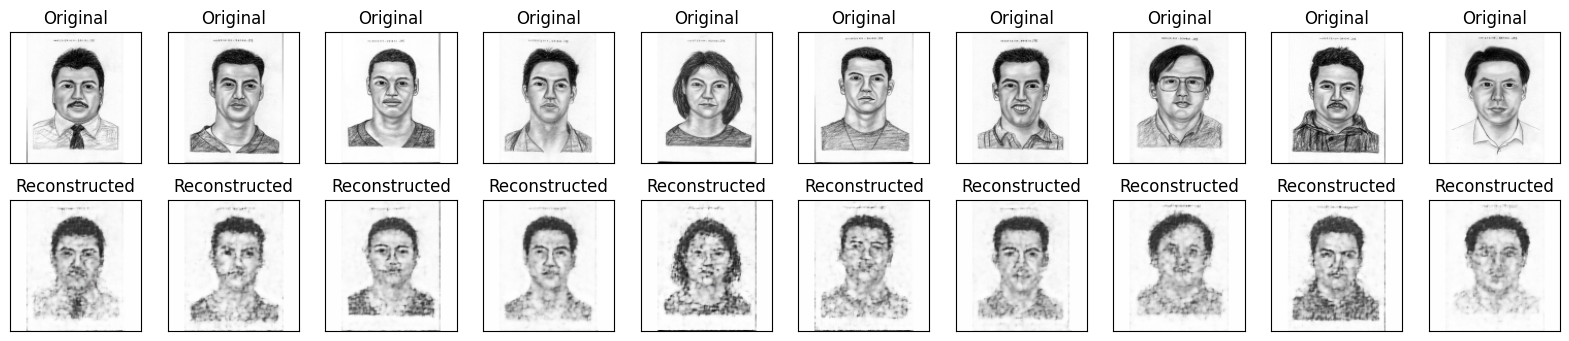

In [8]:

# Plot some original and reconstructed images
# Use matplotlib.pyplot to show the images
n = 10 # number of images to show
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow((x_test[i] + 1) / 2, cmap = 'gray') # rescale the images to [0, 1]
  plt.title("Original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstructed images
  ax = plt.subplot(2, n, i + 1 + n)
  reconstructed = autoencoder.predict(x_test[i:i+1]) # get the reconstructed image
  plt.imshow((reconstructed[0] + 1) / 2) # rescale the images to [0, 1]
  plt.title("Reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# After training by 2000 the constructed images are getting more details
